In [3]:
# 컨브넷을 사용한 시퀀스 처리
# 1D 컨브넷 구현
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000
max_len = 500

print('데이터 로드...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), '훈련 시퀀스')
print(len(x_test), '테스트 시퀀스')

print('시퀀스 패딩 (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train 크기:', x_train.shape)
print('x_test 크기:', x_test.shape)

데이터 로드...
25000 훈련 시퀀스
25000 테스트 시퀀스
시퀀스 패딩 (samples x time)
x_train 크기: (25000, 500)
x_test 크기: (25000, 500)


In [4]:
# imdb 데이터에 1D 컨브넷을 훈련하고 평가하기
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(lr=1e-4),
             loss='binary_crossentropy',
             metrics=['acc'])
history = model.fit(x_train, y_train,
                   epochs=10,
                   batch_size=128,
                   validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
_________________________________________________________________


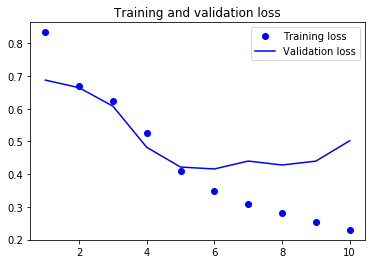

In [7]:
from matplotlib import pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

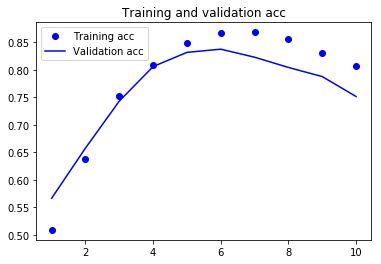

In [9]:
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation acc')
plt.legend()

plt.show()

In [11]:
import os

data_dir = './datasets/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
    
# 데이터 정규화
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows), ))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
        
lookback = 1440
step = 6
delay = 144
batch_size = 128
train_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=0,
                     max_index=200000,
                     shuffle=True,
                     step=step,
                     batch_size=batch_size)

val_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=200001,
                     max_index=300000,
                     step=step,
                     batch_size=batch_size)

test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size # 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수
test_step = (len(float_data) - 300001 - lookback) // batch_size # 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수

In [15]:
test_step

930

In [16]:
# CNN과 RNN을 연결하여 긴 시퀀스를 처리

# 예나 데이터에서 1D 컨브넷을 훈련하고 평가하기
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu', input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                    steps_per_epoch=500,
                   epochs=20,
                   validation_data=val_gen,
                   validation_steps=val_steps)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total para

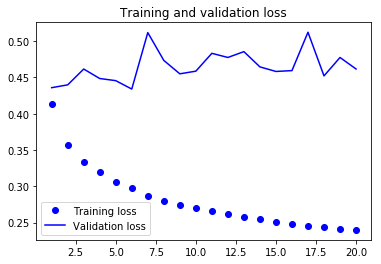

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [19]:
# 고밀도 데이터 제너레이터로 예나 데이터셋 준비
step = 3 # 이전에는 6이었고(시간마다 1 포인트), 이제는 3 (30분마다 1포인트)
lookback = 1440
delay = 144

train_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=0,
                     max_index=200000,
                     shuffle=True,
                     step=step)

val_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=200001,
                     max_index=300000,
                     step=step)

test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step)

val_steps = (300000 - 200001 - lookback) // 128
test_step = (len(float_data) - 300001 - lookback) // 128

In [20]:
# 1D 합성곱과 GRU 층을 연결한 모델
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu', input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                    steps_per_epoch=500,
                   epochs=20,
                   validation_data=val_gen,
                   validation_steps=val_steps)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 13,697
Trainable params: 13,697
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
500/500 [==============================] - 125s 251ms/step - loss: 0.3373 - val_loss: 0.2812
Epoch 2/20
500/500 [==============

In [22]:
history.history

{'val_loss': [0.2811503443716794,
  0.2787465314212484,
  0.2728467786125112,
  0.27455119205389283,
  0.27305142112047215,
  0.2735629549639975,
  0.26925085431209467,
  0.27416517237693033,
  0.2732903001580499,
  0.27866721138726286,
  0.27911635305156013,
  0.28298140148618905,
  0.28902729836102425,
  0.2917037549899753,
  0.29218383190090075,
  0.2961304662906612,
  0.2936718030911428,
  0.29412550871564447,
  0.295831473222092,
  0.2964223832357069],
 'loss': [0.3373049458861351,
  0.30669041338562963,
  0.29323636493086813,
  0.2855601952970028,
  0.2796489491164684,
  0.2761356287896633,
  0.2701239402592182,
  0.2628207363188267,
  0.25917701837420465,
  0.25664437717199323,
  0.25158245873451235,
  0.24586433979868888,
  0.24479117664694786,
  0.24171979933977128,
  0.23753513285517694,
  0.23519864824414252,
  0.23242873033881187,
  0.22886386457085608,
  0.22720410707592964,
  0.22398805293440818]}

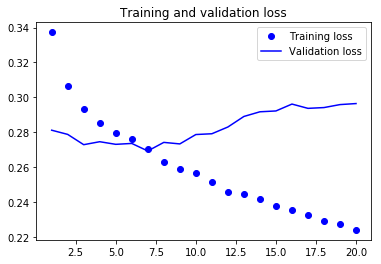

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()